Using device: cpu
Step 1: Loading MNIST dataset and visualization
Training samples: 60000
Test samples: 10000

Class distribution in training set:
labels
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


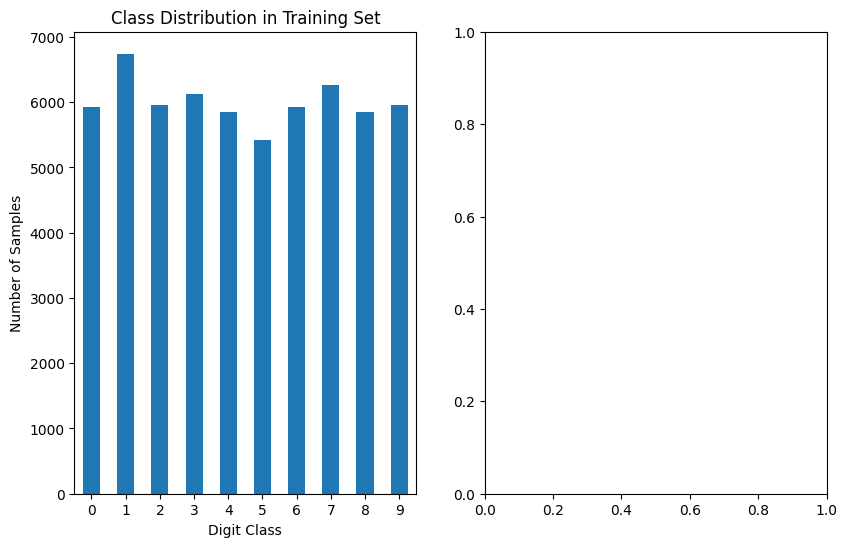

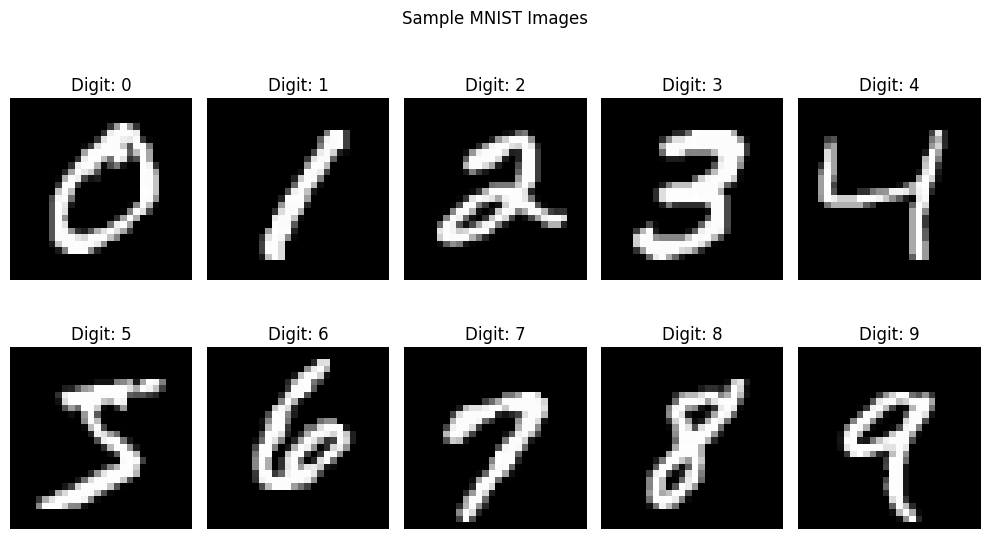


Step 2: Model designing

Model Architecture:
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=576, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc5): Linear(in_features=100, out_features=10, bias=True)
)

Total parameters: 213,270
Trainable parameters: 213,270

Step 3: Training the model

Epoch 1/10
------------------------------
Batch 0/469, Loss: 2.3107, Accuracy: 10.16%
Batch 100/469, Loss: 0.3398, Accuracy: 73.53%
Batch 200/469, Loss: 0.1372, Accuracy: 83.59%
Batch 300/469, Loss: 0.0474, 

In [ ]:
# CNN Implementation using PyTorch - MNIST Classification
# Faculté polydisciplinaire de Ouarzazate - Master IAA & IMSD

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# Step 1: Load Data and Visualization
# =============================================================================

print("Step 1: Loading MNIST dataset and visualization")
print("=" * 50)

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Display class distribution using pandas
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
train_df = pd.DataFrame({'labels': train_labels})
class_distribution = train_df['labels'].value_counts().sort_index()
print(f"\nClass distribution in training set:")
print(class_distribution)

# Visualize class distribution and sample images
plt.figure(figsize=(15, 6))

# Class distribution
plt.subplot(1, 3, 1)
class_distribution.plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)

# Sample images without normalization for visualization
raw_train_dataset = MNIST(root='./data', train=True, download=False,
                         transform=transforms.ToTensor())

# Display sample images
plt.subplot(1, 3, 2)
fig, axes = plt.subplots(2, 5, figsize=(10, 6))
fig.suptitle('Sample MNIST Images')

sample_indices = []
for digit in range(10):
    for i, (_, label) in enumerate(raw_train_dataset):
        if label == digit:
            sample_indices.append(i)
            break

for i, idx in enumerate(sample_indices):
    row = i // 5
    col = i % 5
    image, label = raw_train_dataset[idx]
    axes[row, col].imshow(image.squeeze(), cmap='gray')
    axes[row, col].set_title(f'Digit: {label}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# =============================================================================
# Step 2: Model Designing
# =============================================================================

print("\nStep 2: Model designing")
print("=" * 50)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # conv1: 32 convolutions 5×5, followed by ReLU (with padding to preserve dimensions)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)

        # pool1: max-pooling 2×2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv2: 64 convolutions 5×5, followed by ReLU (with padding to preserve dimensions)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)

        # pool2: max-pooling 2×2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv3: 64 convolutions 5×5, followed by ReLU (with padding to preserve dimensions)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)

        # pool3: max-pooling 2×2
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the input size for the first fully connected layer
        # With padding=2 for 5x5 kernels, spatial dimensions are preserved before pooling
        # After conv1+pool1: 28x28 -> 14x14
        # After conv2+pool2: 14x14 -> 7x7
        # After conv3+pool3: 7x7 -> 3x3 (since 7/2 = 3.5, floor to 3)
        # So we have 64 * 3 * 3 = 576 features
        self.fc4 = nn.Linear(64 * 3 * 3, 100)
        self.dropout = nn.Dropout(0.5)

        # fc5: fully-connected, 10 neurons output, followed by softmax
        self.fc5 = nn.Linear(100, 10)

    def forward(self, x):
        # conv1 + ReLU + pool1
        x = self.pool1(F.relu(self.conv1(x)))

        # conv2 + ReLU + pool2
        x = self.pool2(F.relu(self.conv2(x)))

        # conv3 + ReLU + pool3
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # fc4 + ReLU + dropout
        x = self.dropout(F.relu(self.fc4(x)))

        # fc5 + softmax (softmax applied in loss function)
        x = self.fc5(x)

        return x

# Create model instance
model = CNN().to(device)

# Set hyperparameters
learning_rate = 0.001
num_epochs = 10

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Display model architecture
print("\nModel Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# =============================================================================
# Step 3: Train
# =============================================================================

print("\nStep 3: Training the model")
print("=" * 50)

# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, '
                  f'Accuracy: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Testing function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, target).item()

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# Training loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 30)

    # Train
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)

    # Test
    test_loss, test_acc = test_model(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# Step 4: Test
# =============================================================================

print("\nStep 4: Testing the model")
print("=" * 50)

# Final evaluation
final_test_loss, final_test_acc = test_model(model, test_loader, criterion, device)
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

# Get predictions for confusion matrix
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.numpy())

# Display some test results
plt.figure(figsize=(12, 8))
test_samples = []
test_labels = []
test_predictions = []

# Get some test samples for visualization
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)

        # Take first 12 samples
        for j in range(min(12, data.size(0))):
            if len(test_samples) < 12:
                test_samples.append(data[j].cpu())
                test_labels.append(target[j].item())
                test_predictions.append(predicted[j].cpu().item())

        if len(test_samples) >= 12:
            break

for i in range(12):
    plt.subplot(3, 4, i + 1)
    # Denormalize the image for display
    img = test_samples[i].squeeze() * 0.3081 + 0.1307
    img = torch.clamp(img, 0, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {test_labels[i]}, Pred: {test_predictions[i]}')
    plt.axis('off')

plt.suptitle('Test Results - True vs Predicted Labels')
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions))

print("\nPyTorch CNN Implementation Complete!")
print("=" * 50)